## Импорт необходимых библиотек

In [71]:
import numpy as np
import pandas as pd
import string
from collections import Counter
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

import os
import librosa
import soundfile as sf
import requests
import subprocess

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.utils.rnn as rnn_utils
import torch.nn.functional as F
import deepspeech

import warnings
warnings.filterwarnings('ignore')

# 1. Загрузка данных

Первым делом я сооздал датасет с путями к каждому аудиофайлу и транскрипцией/расшифровкой этого файла.

In [36]:
data_dir = "data/"

audio_files = []
transcription_files = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".opus"):
            audio_file_path = os.path.join(root, file)
            txt_file_path = os.path.join(root, file.replace(".opus", ".txt"))
            audio_files.append(audio_file_path)
            transcription_files.append(txt_file_path)

In [37]:
paths_df = pd.DataFrame(columns=['audio_path', 'transcription'])

paths_df['audio_path'] = audio_files
paths_df['transcription'] = transcription_files

paths_df.head()

,audio_path,transcription
0,data/public_youtube1120_hq\0\00\03de1fb6b14c.opus,data/public_youtube1120_hq\0\00\03de1fb6b14c.txt
1,data/public_youtube1120_hq\0\00\088e77d8f166.opus,data/public_youtube1120_hq\0\00\088e77d8f166.txt
2,data/public_youtube1120_hq\0\00\0a82bb9fa4f5.opus,data/public_youtube1120_hq\0\00\0a82bb9fa4f5.txt
3,data/public_youtube1120_hq\0\00\0c49e5869662.opus,data/public_youtube1120_hq\0\00\0c49e5869662.txt
4,data/public_youtube1120_hq\0\00\0e3ea7c53255.opus,data/public_youtube1120_hq\0\00\0e3ea7c53255.txt


In [38]:
paths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369212 entries, 0 to 369211
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   audio_path     369212 non-null  object
 1   transcription  369212 non-null  object
dtypes: object(2)
memory usage: 5.6+ MB


--------

Так как объем данных довольно громоздкий, я решил взять 1/5 его часть для дальнейшей работы. Эта часть должна адекватно описывать данные и не должна привести к каким-либо проблемам или недостаткам у модели в дальнейшем.

In [39]:
paths_df = paths_df[:len(paths_df)//5]

print("Размер датасета:", paths_df.shape)

Размер датасета: (73842, 2)


Готово, теперь можно переходить к обработке данных.

# 2. Предобработка и разделение данных

Перед тем как производить какие-либо действия с данными, стоит вообще взглянуть на них.

In [40]:
audio_durations = []
transcription_lengths = []

# Прохожусь по файлам, собираю в списки длину аудиозаписей и расшифровок
for index, row in paths_df.iterrows(): 
    audio_path = row['audio_path']
    transcription_path = row['transcription']

    audio, sr = librosa.load(audio_path, sr=None)
    audio_duration = librosa.get_duration(y=audio, sr=sr)

    with open(transcription_path, 'r', encoding='utf-8') as file:
        transcription = file.read().strip()
    transcription_length = len(transcription.split())

    audio_durations.append(audio_duration)
    transcription_lengths.append(transcription_length)

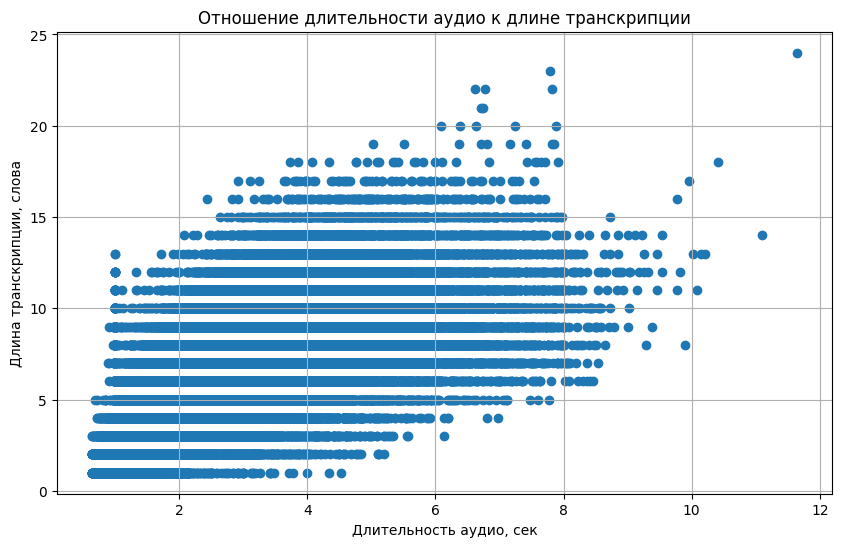

In [41]:
plt.figure(figsize=(10, 6))
plt.scatter(audio_durations, transcription_lengths)
plt.title('Отношение длительности аудио к длине транскрипции')
plt.xlabel('Длительность аудио, сек')
plt.ylabel('Длина транскрипции, слова')
plt.grid(True)
plt.show()

In [42]:
print('Количество записей которые длятся 0 секунд =', audio_durations.count(0))
print('Количество транскрипций, в которых 0 слов =', transcription_lengths.count(0))

Количество записей которые длятся 0 секунд = 0
Количество транскрипций, в которых 0 слов = 0


>

Отлично! В наших данных нету таких явных выбросов, как пустые записи и расшифровки. Также, на графике выше явно можно наблюдать, что длина аудиозаписей положительно коррелирует с длиной транскрипций. Это хороший знак, ведь если бы было наоборот, было бы как минимум очень странно, и адекватность данных бы тогда ставилась под большой вопрос.

Самые явные шумы находятся слева сверху на графике - записи, которые длятся около секунды, при этом содержащие 10+ слов. Стоит изучить этот момент.

In [43]:
# ищем индексы проверяя значения в двух списках
idx = []
for index, (value1, value2) in enumerate(zip(transcription_lengths, audio_durations)):
    if (value1 >= 10) and (value2 >= 0.9 and value2 <= 1.1):
        print(f"Индекс записи в которой {value1} слов и которая длится {value2} секунд(ы): {index}")
        idx.append(index)

Индекс записи в которой 10 слов и которая длится 1.0 секунд(ы): 107
Индекс записи в которой 10 слов и которая длится 1.0 секунд(ы): 4083
Индекс записи в которой 11 слов и которая длится 1.0 секунд(ы): 4474
Индекс записи в которой 10 слов и которая длится 1.0 секунд(ы): 5988
Индекс записи в которой 11 слов и которая длится 1.0 секунд(ы): 6392
Индекс записи в которой 12 слов и которая длится 1.0 секунд(ы): 7454
Индекс записи в которой 11 слов и которая длится 1.0 секунд(ы): 9887
Индекс записи в которой 11 слов и которая длится 1.0 секунд(ы): 10539
Индекс записи в которой 10 слов и которая длится 1.0 секунд(ы): 11056
Индекс записи в которой 10 слов и которая длится 1.0 секунд(ы): 11243
Индекс записи в которой 12 слов и которая длится 1.0 секунд(ы): 11813
Индекс записи в которой 10 слов и которая длится 1.0 секунд(ы): 12435
Индекс записи в которой 10 слов и которая длится 1.0 секунд(ы): 14349
Индекс записи в которой 13 слов и которая длится 1.0 секунд(ы): 14414
Индекс записи в которой 10 с

----

Как мы видим, действительно есть такие выбивающиеся записи, которые к тому же длятся ровно одну секунду. Сами записи слушать уже точно необязательно, и так ясно что это выбросы. От них лучше избавиться.

In [44]:
idx.sort(reverse=True)

paths_df = paths_df.drop(idx)
for index in idx:
    del audio_durations[index]
    del transcription_lengths[index]

In [45]:
# убедимся что этих записей больше нет, запустив тот же код
for index, (value1, value2) in enumerate(zip(transcription_lengths, audio_durations)):
    if (value1 >= 10) and (value2 >= 0.9 and value2 <= 1.1):
        print(f"Индекс записи в которой 20 слов и которая длится {value2} секунд(ы): {index}")

Код ничего не выводит, а значит, что от выбросов мы избавились.

------

Теперь я приступлю к предварительной обработке аудиофайлов - самым логичным, что можно сделать это выполнить нормализацию громкости и уменьшение шума.

In [46]:
pre_folder = "preprocessed_data"
os.makedirs(pre_folder, exist_ok=True)

In [47]:
def normalize_audio(audio):
    '''Функция для нормализации громкости аудио'''
    normalized_audio = librosa.util.normalize(audio)
    return normalized_audio

def reduce_noise(audio):
    '''Функция для уменьшения шума в аудио'''
    reduced_noise_audio = librosa.effects.preemphasis(audio)
    return reduced_noise_audio

In [48]:
for index, row in paths_df.iterrows():
    audio_path = row['audio_path']
    audio, sr = librosa.load(audio_path, sr=None)
    
    normalized_audio = normalize_audio(audio)
    noise_reduced_audio = reduce_noise(normalized_audio)

    sf.write(f"preprocessed_data/{index}_processed.wav", noise_reduced_audio, sr) # записываю обработанный файл

-----

Теперь к расшифровкам - у текстовых данных я решил удалить пунктуацию и привести все к нижнему регистру.

In [49]:
def remove_punctuation(text):
    '''Создает таблицу трансляции для удаления пунктуации, затем непосредственно удаляет ее.'''
    translator = str.maketrans('', '', string.punctuation)
    no_punctuation = text.translate(translator)
    return no_punctuation

def lowercase_text(text):
    '''Приводит текст к нижнему регистру.'''
    return text.lower()

In [50]:
for index, row in paths_df.iterrows():
    t_path = row['transcription']
    processed_path = os.path.join('preprocessed_data', f"{index}_processed.txt")

    with open(t_path, 'r', encoding='utf-8') as file:
        transcription = file.read().strip()
    no_punct = remove_punctuation(transcription)
    lowercase_t = lowercase_text(no_punct)

    with open(processed_path, 'w', encoding='utf-8') as processed_file:
        processed_file.write(lowercase_t)

Теперь создадим новый датафрейм, который содержит пути к уже обработанным файлам.

In [51]:
pre_paths = []

for file in os.listdir(pre_folder):
    if file.endswith('.wav'):
        audio_path = os.path.join(pre_folder, file)
        transcript_path = os.path.join(pre_folder, file[:-4] + '.txt')
        
        if os.path.exists(transcript_path):
            pre_paths.append({'audio_path': audio_path, 'transcript_path': transcript_path})

In [52]:
df = pd.DataFrame(pre_paths)
df.head()

,audio_path,transcript_path
0,preprocessed_data\0_processed.wav,preprocessed_data\0_processed.txt
1,preprocessed_data\10000_processed.wav,preprocessed_data\10000_processed.txt
2,preprocessed_data\10001_processed.wav,preprocessed_data\10001_processed.txt
3,preprocessed_data\10002_processed.wav,preprocessed_data\10002_processed.txt
4,preprocessed_data\10003_processed.wav,preprocessed_data\10003_processed.txt


In [53]:
df.shape

(73758, 2)

---

Взглянем на основные характеристики, для дальнейшего использования в модели

In [58]:
frequencies = []
durations = []
num_time_steps = []
num_freq_bins = []
unique_characters = set()

for index, row in df.iterrows():
    audio_path = row['audio_path']
    audio, sr = librosa.load(audio_path, sr=None)
    frequencies.append(sr)
    durations.append(float(len(audio)) / sr)
    spectrogram = librosa.stft(audio)
    num_time_steps.append(spectrogram.shape[1])
    num_freq_bins.append(spectrogram.shape[0])
    
    transcript_path = row['transcript_path']
    with open(transcript_path, 'r', encoding='utf-8') as file:
        transcript = file.read().strip()
        unique_characters.update(set(transcript))

print("Характеристики аудиофайлов:")
print("Средняя частота:", sum(frequencies) / len(frequencies))
print("Средняя длительность:", sum(durations) / len(durations))
print("Среднее количество временных 'шагов' в спектрограмме:", sum(num_time_steps) / len(num_time_steps))
print('-------------')
print("Характеристики транскрипций:")
print("Уникальные символы:", unique_characters)
print("Количество уникальных символов:", len(unique_characters))

Характеристики аудиофайлов:
Средняя частота: 16000.0
Средняя длительность: 2.84275049909838
Среднее количество временных 'шагов' в спектрограмме: 89.37778952791561
-------------
Характеристики транскрипций:
Уникальные символы: {'y', 'к', 'ё', 'в', 'д', 'ш', 'п', 'я', 'г', 'у', 'щ', 'ч', 'т', 'ц', 'э', 'з', 'м', 'ф', 'q', 'с', 'ы', 'е', 'б', 'й', 'х', 'р', 'а', ' ', 'о', 'н', 'л', 'ъ', 'ь', 'ю', 'и', 'ж'}
Количество уникальных символов: 36


-----

Перед тем как делить данные на выборки, я сделаю преобразование аудиофайлов и текстовых транскрипций в формат, пригодный для обучения модели:
* Для аудиоданных я создаю спектрограммы.
* Для текстовых данных я использую преобразование текста в числовой формат.

In [59]:
def audio_to_spectrogram(audio_path, n_fft=2048, hop_length=512):
    '''Создает спектрограмму из аудиофайла'''
    audio, sr = librosa.load(audio_path, sr=None)
    spectrogram = np.abs(librosa.stft(audio, n_fft=n_fft, hop_length=hop_length))
    
    return spectrogram

def transcript_to_tensor(transcript_path, tokenizer, vocab):
    '''Приводит текстовые транскрипции к численому представлению'''
    with open(transcript_path, 'r', encoding='utf-8') as file:
        transcript = file.read().strip()
    tokens = tokenizer(transcript)
    tensor = torch.tensor([vocab[token] for token in tokens if token in vocab], dtype=torch.long)
    
    return tensor

In [60]:
trans_folder = "transformed_data"
os.makedirs(trans_folder, exist_ok=True)

tokenizer = word_tokenize
vocab = set()

In [61]:
for _, row in df.iterrows():
    transcript_path = row['transcript_path']
    with open(transcript_path, 'r', encoding='utf-8') as file:
        transcript = file.read().strip()
        tokens = tokenizer(transcript)
        vocab.update(tokens)

vocab_to_index = {token: index for index, token in enumerate(vocab)}

for index, row in df.iterrows():
    audio_path = row['audio_path']
    transcript_path = row['transcript_path']
    
    file_name = os.path.splitext(os.path.basename(audio_path))[0]
    
    spectrogram = audio_to_spectrogram(audio_path)
    spectrogram_path = os.path.join(trans_folder, f"{file_name}_spectrogramm.pt")
    torch.save(torch.tensor(spectrogram), spectrogram_path)
    
    transcript_tensor = transcript_to_tensor(transcript_path, tokenizer, vocab_to_index)
    transcript_tensor_path = os.path.join(trans_folder, f"{file_name}_transcript.pt")
    torch.save(transcript_tensor, transcript_tensor_path)

---

Создаем финальный датасет который содержит пути к спектограммам и измененному тексту (который уже не текст). На этих данных я и буду обучать модели в будущем.

In [62]:
files = sorted(os.listdir(trans_folder))

data = []
for filename in files:
    if filename[:-3].endswith("spectrogramm"):
        spectrogram_path = os.path.join(trans_folder, filename)
        transcript_filename = filename.replace("_spectrogramm.pt", "_transcript.pt")
        transcript_path = os.path.join(trans_folder, transcript_filename)
        data.append({'spectrogram_path': spectrogram_path, 'transcript_path': transcript_path})

# Создание датафрейма
final_df = pd.DataFrame(data)

In [63]:
final_df.head()

,spectrogram_path,transcript_path
0,transformed_data\0_processed_spectrogramm.pt,transformed_data\0_processed_transcript.pt
1,transformed_data\10000_processed_spectrogramm.pt,transformed_data\10000_processed_transcript.pt
2,transformed_data\10001_processed_spectrogramm.pt,transformed_data\10001_processed_transcript.pt
3,transformed_data\10002_processed_spectrogramm.pt,transformed_data\10002_processed_transcript.pt
4,transformed_data\10003_processed_spectrogramm.pt,transformed_data\10003_processed_transcript.pt


In [64]:
final_df.shape # размер датасета не изменился, значит все хорошо

(73758, 2)

-----

Ну и наконец можно перейти к разделению данных на обучающую, валидационную и тестовую выборки. Я буду делить их в пропорции 60/20/20

In [65]:
train_df, test_df = train_test_split(final_df, test_size=0.4, random_state=17)
valid_df, test_df = train_test_split(test_df, test_size=0.5, random_state=17)

print("Размер обучающей выборки:", len(train_df))
print("Размер валидационной выборки:", len(valid_df))
print("Размер тестовой выборки:", len(test_df))

Размер обучающей выборки: 44254
Размер валидационной выборки: 14752
Размер тестовой выборки: 14752


----

# 3. Выбор моделей и метрик.

Перед тем как выбирать модели обязательно надо определиться с метриками. В задаче распознавания речи есть несколько стандартных метрик, которые можно использовать для оценки качества модели, я выбрал следующие:
1) Word Error Rate (WER) - измеряет процент ошибок в распознавании слов. WER рассчитывается как отношение общего количества вставок, удалений и замен слов к общему количеству слов в тексте.
2) Character Error Rate (CER) - измеряет процент ошибок в распознавании символов. CER рассчитывается как отношение общего количества вставок, удалений и замен символов к общему количеству символов в тексте.
3) Accuracy - измеряет процент правильно распознанных слов или символов.

Есть и другие метрики, как например BLEU и ROUGE, но они предназначены немного для других целей. Я же выбрал именно эти метрики, так как они мне показались наиболее логичными в рамках поставленной задачи, ведь я не ставил каких-то более глубоких целей, чем обычное распознавание русской речи. 

----

Теперь выбор моделей. Очевидно то, что для задачи распознавания текста используются нейронные сети. Я решил реализовать свои модели и посмотреть на результат.

Среди моделей которые я выбрал RNN-Transducer (рекуррентные сети) и трансформеры, подробнее о них ниже:

------

Основное отличие рекуррентных нейронных сетей от других сетей заключается в их рекуррентной структуре. В каждый момент времени RNN принимает входные данные и состояние сети на предыдущем временном шаге и использует их для генерации выхода и обновления своего внутреннего состояния. Одна из главных особенностей RNN - это возможность сохранять информацию о предыдущих состояниях и использовать ее для обработки последующих данных. Это позволяет ей учитывать контекст в последовательных данных и улавливать долгосрочные зависимости.

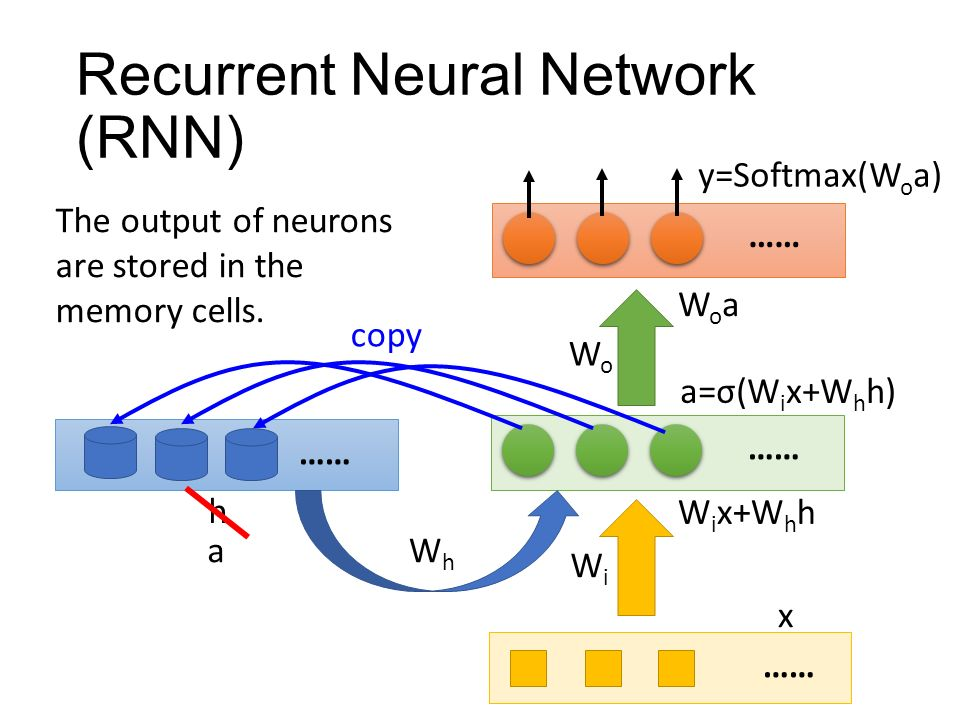

RNN-Transducer - это архитектура модели, специально разработанная для задач распознавания речи и других последовательных модельных задач, где входные и выходные последовательности могут иметь разную длину. В отличие от обычных рекуррентных нейронных сетей (RNN), которые могут работать только с последовательными входными и выходными данными фиксированной длины, RNN-Transducer позволяет моделировать последовательности переменной длины. Именно этот факт невероятно важен в нашей задаче, ведь наши данные динамичны.


## Внимание! Дальше идет код, на который я убил очень много времени и сил, но который я так и не смог довести до логического конца, тем не менее имеющий под собой большой фундамент и на который я потратил большую часть времени.
Я провел очень большое кол-во времени пытаясь реализовать свою модель. Я столкнулся с множеством проблем и ошибок, среди которых:
- Постоянные проблемы с размерами тензоров: не смотря на то, что по сути в задаче по распознаванию текстов нужно чтобы принимались разноразмерные тензоры, я просто не смог сделать так чтобы в батчи засовывались тензоры разных размеров. Меня бесконечно преследовали ошибки с размерами тензоров, как бы я не пытался преобразовать данные, в результате помогла интерполяция, и ошибки больше не было.
- Ошибки у функции потерь. Она также то жаловалась на не те размеры передаваемых данных, на типы данных, на то, что батчи и результаты модели неправильные и многое другое. Все это мне удалось пофиксить путем очень долгих попыток.
- Функция потерь выдает NaN. Очень длительное время я искал причины, которые приводили к тому что моя функция потерь выдавала постоянно NaN значения. Я пробовал менять объем подаваемых данных, размеры, слои у модели, в результате мне удалось понять, что суть проблемы в том, что функция потерь не может посчитать соответствующие данные по той причине, что в данных есть нули, которыми я заполнял тензоры чтобы они были одного размера (да, это выходит из первой проблемы). Я начал передавать другие значения, но (переход к заключительной проблеме).
- Функция потерь равна бесконечности. Здесь уже что бы я не пробовал, ничего не могло решить эту проблему.

По сути я сам себя загнал в цикл нерешаемых проблем, потому что проблема с бесконечностью явно исходит из того, что я как-то обрабатываю спектрограммы, меняя их размеры и т.д. 
Возможно, будь у меня больше времени и опыта я бы смог перелопатить всю логику кода, но к моему сожалению я уже отдал львиную долю своего времени на попытки исправить то, что я описал выше.

Сначала надо было немного преобразовать данные:

In [30]:
class CustomDataset(Dataset):
    ''' Загружает спектрограммы в тензоры;
        Применяет интерполяцию для изменения размерности тензоров, чтобы потом их можно было передать в модель;
        Меняет размер транскрипций до заданного target_length, заполняя их значениями (-1). Именно это значение, чтобы функция потерь не воспринимала эти значения за метки классов'''
    def __init__(self, spectrogram_paths, transcript_paths, target_length):
        self.spectrogram_paths = spectrogram_paths
        self.transcript_paths = transcript_paths
        self.target_length = target_length
    
    def __len__(self):
        return len(self.spectrogram_paths)
    
    def __getitem__(self, idx):
        spectrogram = torch.load(self.spectrogram_paths[idx])
        transcript = torch.load(self.transcript_paths[idx])
        
        spectrogram = F.interpolate(spectrogram.unsqueeze(0), size=self.target_length, mode='linear').squeeze(0)
        spectrogram[spectrogram == 0] = 0.0000001 # функция потерь не принимает 0
        
        if len(transcript) > self.target_length:
            transcript = transcript[:self.target_length]
        elif len(transcript) < self.target_length:
            pad_amount = self.target_length - len(transcript)
            transcript = torch.nn.functional.pad(transcript, (0, pad_amount), value=1)
        
        return spectrogram, transcript

def create_dataloader(df, target_length):
    ''' Преобразует датафрейм в соответсвующий датасет;
        Загружает полученный датасет в DataLoader который далее используется в обучении.'''
    spectrogram_paths = df['spectrogram_path'].tolist()
    transcript_paths = df['transcript_path'].tolist()
    
    dataset = CustomDataset(spectrogram_paths, transcript_paths, target_length)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader

batch_size = 32
target_length = 128

train_loader = create_dataloader(train_df, target_length)
valid_loader = create_dataloader(valid_df, target_length)
test_loader = create_dataloader(test_df, target_length)

Ну и сама модель:

In [31]:
class RNNTransducer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNNTransducer, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        
        self.prediction_network = nn.Linear(hidden_size, output_size)
        
        self.joint_network = nn.Linear(hidden_size * 2, hidden_size)
        
        self.decoder = nn.LSTMCell(output_size + hidden_size, hidden_size)
        
    def forward(self, spectrogram, transcript):
        encoder_outputs, _ = self.encoder(spectrogram)

        predictions = self.prediction_network(encoder_outputs)
        
        batch_size = spectrogram.size(0)
        
        max_seq_len = transcript.size(1)
        
        hidden = torch.zeros(batch_size, self.hidden_size, device=spectrogram.device)
        
        cell = torch.zeros(batch_size, self.hidden_size, device=spectrogram.device)
        
        outputs = []
        for t in range(max_seq_len):
            attention_weights = F.softmax(torch.bmm(encoder_outputs, hidden.unsqueeze(2)).squeeze(2), dim=1)
            
            context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)
            
            input = torch.cat((context, predictions[:, t, :]), dim=1)
            
            hidden, cell = self.decoder(input, (hidden, cell))
            
            joint_output = self.joint_network(torch.cat((hidden, context), dim=1))
            
            output = self.prediction_network(joint_output)
            
            outputs.append(output)
        
        return torch.stack(outputs, dim=1)

input_size = 128
hidden_size = 256
output_size = len(vocab)

model = RNNTransducer(input_size, hidden_size, output_size, num_layers=3)

print("Веса энкодера:", model.encoder.weight_ih_l0)
print("Веса декодера:", model.decoder.weight_ih)

Веса энкодера: Parameter containing:
tensor([[ 0.0066,  0.0538, -0.0367,  ...,  0.0111,  0.0500,  0.0359],
        [-0.0269,  0.0107,  0.0364,  ..., -0.0436, -0.0510, -0.0584],
        [ 0.0324,  0.0471,  0.0232,  ..., -0.0092,  0.0077, -0.0596],
        ...,
        [ 0.0275,  0.0092,  0.0107,  ..., -0.0256,  0.0370,  0.0159],
        [ 0.0023,  0.0479, -0.0492,  ...,  0.0299, -0.0427,  0.0052],
        [-0.0527,  0.0119, -0.0619,  ..., -0.0131, -0.0200, -0.0341]],
       requires_grad=True)
Веса декодера: Parameter containing:
tensor([[-0.0058, -0.0550, -0.0437,  ..., -0.0287,  0.0473,  0.0623],
        [ 0.0264,  0.0320, -0.0243,  ...,  0.0406, -0.0133, -0.0598],
        [ 0.0441,  0.0512, -0.0293,  ..., -0.0255, -0.0449, -0.0317],
        ...,
        [-0.0319,  0.0573,  0.0067,  ...,  0.0067, -0.0118, -0.0415],
        [-0.0070,  0.0276,  0.0038,  ..., -0.0036, -0.0416,  0.0110],
        [-0.0426, -0.0039,  0.0353,  ..., -0.0552, -0.0416, -0.0124]],
       requires_grad=True)


Теперь надо определиться с функцией потерь и оптимизатором. Идеальными вариантами будет Connectionist Temporal Classification и Adam, которые чаще всего используются в задаче по распознаванию текста.

Суть CTC состоит в том, что она классифицирует метки с упором на их последовательность. Именно эта особенность важна нам.

In [33]:
criterion = nn.CTCLoss()
optimizer = torch.optim.Adam(model.parameters())

Ну и приступим к обучению модели:

In [34]:
def train_model(model, criterion, optimizer, train_loader, valid_loader, epochs):
    ''' Функция обучения модели;
        Передает батчи в модель, после чего данные полученные из модели передаются в CTC функцию потерь;
        Выводит ФП для обучающего набора, затем для валидационного;
        Рисует график на котором отображается функция потерь со временем обучения.'''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    train_losses = []
    valid_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for spectrogram_batch, transcript_batch in train_loader:
            spectrogram_batch = spectrogram_batch.to(device)
            transcript_batch = transcript_batch.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(spectrogram_batch, transcript_batch)
            
            # длины последовательностей
            input_lengths = spectrogram_batch.size(2) * torch.ones(spectrogram_batch.size(0), dtype=torch.long, device=device)
            target_lengths = transcript_batch.size(1) * torch.ones(transcript_batch.size(0), dtype=torch.long, device=device)
            
            # рассчет потерь
            loss = criterion(outputs.permute(1, 0, 2), transcript_batch, input_lengths, target_lengths)
            
            # !ОТЛАДКА!
            print(f"Batch Loss: {loss.item()}")
            # !/ОТЛАДКА!
            
            # Обратное распространение и оптимизация
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # средняя потеря на обучающем наборе
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}")
        
        # качество модели на валидационном наборе
        valid_loss = evaluate_model(model, criterion, valid_loader, device)
        valid_losses.append(valid_loss)
        print(f"Epoch {epoch+1}/{epochs}, Valid Loss: {valid_loss:.4f}")
        
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def evaluate_model(model, criterion, data_loader, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for spectrogram_batch, transcript_batch in data_loader:
            spectrogram_batch = spectrogram_batch.to(device)
            transcript_batch = transcript_batch.to(device)
            
            outputs = model(spectrogram_batch, transcript_batch)
            
            # длины последовательностей
            input_lengths = spectrogram_batch.size(2) * torch.ones(spectrogram_batch.size(0), dtype=torch.long, device=device)
            target_lengths = transcript_batch.size(1) * torch.ones(transcript_batch.size(0), dtype=torch.long, device=device)
            
            # потери
            loss = criterion(outputs.permute(1, 0, 2), transcript_batch, input_lengths, target_lengths)
            
            total_loss += loss.item()
    
    return total_loss / len(data_loader)

In [35]:
epochs = 10
train_model(model, criterion, optimizer, train_loader, valid_loader, epochs)

Batch Loss: inf
Batch Loss: nan
Batch Loss: nan
Batch Loss: nan
Batch Loss: nan
Batch Loss: nan
Batch Loss: nan
Batch Loss: nan
Batch Loss: nan
Batch Loss: nan
Batch Loss: nan
Batch Loss: nan
Batch Loss: nan
Batch Loss: nan
Epoch 1/10, Train Loss: nan
Epoch 1/10, Valid Loss: nan


KeyboardInterrupt: 

### 4. Метрики, выводы